## Phase I - Baseline Model Design and Review - HH

### Pull in Data

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import os

from tensorflow import keras
from tensorflow.keras import layers, regularizers  ### Adding 'regularizers'
from tensorflow.keras.models import Sequential
import pathlib

In [3]:
# Specify the path to the zip file
dataset_url = "https://dl.dropboxusercontent.com/scl/fi/hgz1prxm1kx14w5riy9du/ls_model_data_three.zip?rlkey=7cv22qxmmaeofr7jn6z7iayjy&dl=0?raw=1"

In [4]:
data_dir = tf.keras.utils.get_file('ls_model_data_three.zip', origin=dataset_url, extract=True)
data_dir = pathlib.Path(data_dir).with_suffix('')

In [5]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

2000


In [6]:
## Review folders in incoming data / classes
folders = [folder for folder in data_dir.glob('*') if folder.is_dir()]
print("Folders in the dataset directory:")
for folder in folders:
    print(folder.name)

Folders in the dataset directory:
landslide
non_landslide


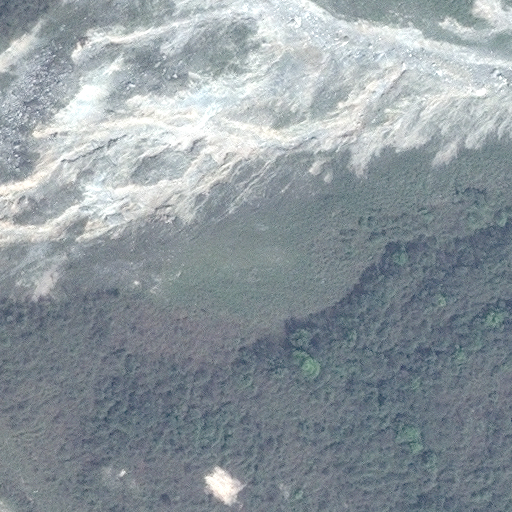

In [7]:
## Review an image
landslide_one = list(data_dir.glob('landslide/*'))
PIL.Image.open(str(landslide_one[0]))

## Set up Data Sets for model input

In [8]:
## Set Batch, Image size and number of Classes. 
batch_size = 32
img_height = 300
img_width = 300
land_class_num = len(folders)

In [9]:
## Set Training Set image set. 
train_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.25,
  subset="training",
  seed=512,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2000 files belonging to 2 classes.
Using 1500 files for training.


2024-11-01 17:40:24.883373: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43483 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:84:00.0, compute capability: 8.6


In [10]:
## Setup Valiation set.
valid_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.25,
  subset="validation",
  seed=512,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2000 files belonging to 2 classes.
Using 500 files for validation.


In [11]:
## Review class names based on dataset. 
class_names = train_dataset.class_names
print(class_names)

['landslide', 'non_landslide']


In [12]:
## Review sizes of images. 
counter_d = 0
for images, labels in train_dataset:
    if counter_d < 3:
        print(images.shape, labels.shape)
    counter_d += 1

(32, 300, 300, 3) (32,)
(32, 300, 300, 3) (32,)
(32, 300, 300, 3) (32,)


2024-11-01 17:40:31.668944: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [13]:
## Data Performance
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
valid_dataset = valid_dataset.cache().prefetch(buffer_size=AUTOTUNE)

2024-11-01 17:40:35.304159: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


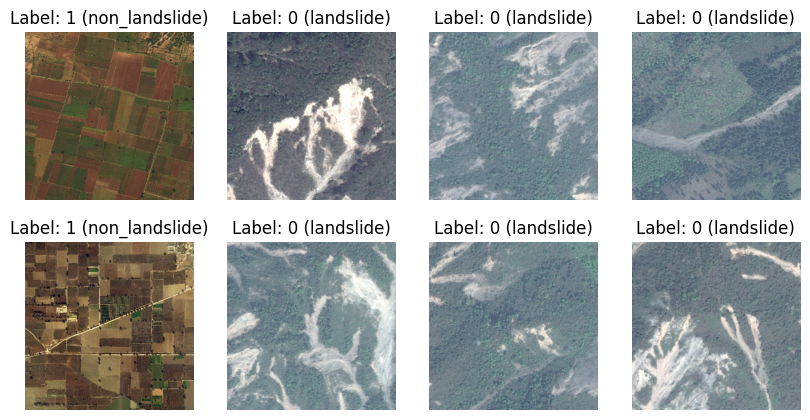

In [14]:
## Checking the Labels. 
plt.figure(figsize=(10, 5))
for images, labels in train_dataset.take(1):  # Take one batch
    for i in range(8):  # Display first 6 samples
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        label = labels[i].numpy()
        label_name = class_names[label] if 'class_names' in locals() else label
        plt.title(f"Label: {label} ({label_name})")
        plt.axis("off")
plt.show()


----

## Model

In [15]:
### Adding helper method for print option. 
def visualize_model_results(model_input):
    acc = model_input.history['accuracy']
    val_acc = model_input.history['val_accuracy']

    loss = model_input.history['loss']
    val_loss = model_input.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

<hr style="border:2px solid gray">

### Design Model

In [48]:
ls_model_ph_one = Sequential([
  # data_augmentation,  ## Data Augmentation
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 2, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 2, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 2, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    # layers.Dropout(0.2),  ## Dropout
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),  ## Dropout
    layers.Dense(2, activation='softmax')   ### Use with SparseCategoricalCrossentropy
    # layers.Dense(1, activation='sigmoid')   ### Use with BinaryCrossentropy
])

In [49]:
## Setup model: Optmizer, Loss, Metrics
ls_model_ph_one.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=.001),
            loss='sparse_categorical_crossentropy',
              # loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                         # loss='binary_crossentropy',
              metrics=['accuracy'])

In [50]:
ls_model_ph_one.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_4 (Rescaling)         │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 300, 300, 16)   │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 150, 150, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 150, 150, 32)   │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 75, 75, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 87616)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │     2,803,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,814,354 (10.74 MB)

 Trainable params: 2,814,354 (10.74 MB)

 Non-trainable params: 0 (0.00 B)

In [51]:
## Fit Model
epochs = 10
landslide_history_one = ls_model_ph_one.fit(
  train_dataset,
  validation_data=valid_dataset,
  epochs=epochs
)

Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - accuracy: 0.4993 - loss: 0.6740 - val_accuracy: 0.5100 - val_loss: 0.6199
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7154 - loss: 0.5892 - val_accuracy: 0.9480 - val_loss: 0.5124
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9705 - loss: 0.4703 - val_accuracy: 0.9920 - val_loss: 0.3771
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9902 - loss: 0.3376 - val_accuracy: 0.9900 - val_loss: 0.2529
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9857 - loss: 0.2372 - val_accuracy: 0.9940 - val_loss: 0.1650
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9951 - loss: 0.1588 - val_accuracy: 0.9940 - val_loss: 0.1139
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9949 - loss: 0.1115 - val_accuracy: 0.9960 - val_loss: 0.0829
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9931 - loss: 0.0852 - val_accuracy: 0.9920 - v

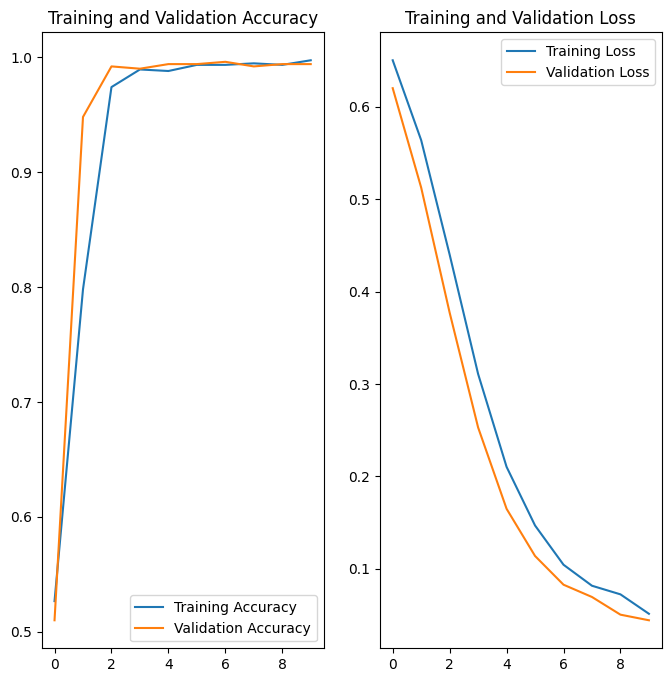

In [52]:
## Plot results
visualize_model_results(landslide_history_one)

<hr style="border:2px solid gray">

## Testing a single image.

In [24]:
## Create Prediction Helper Function:
def predict_landslide_image(image_path, model):
    img = tf.keras.utils.load_img(
        image_path, target_size=(img_height, img_width) )

    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    # score = tf.nn.softmax(predictions[0])
    score = predictions[0]

    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )

---

#### Image One

In [25]:
## Load Image
landslide_img_one_url = "https://dl.dropboxusercontent.com/scl/fi/pww2k3qd09pqmxh2fa4ny/NASA_GoogE_13710.jpg?rlkey=2kcfu8i5pzgb0zjotss1xy2hd&dl=0?raw=1"
landslide_img_one_path = tf.keras.utils.get_file('NASA_GoogE_13710', origin=landslide_img_one_url)

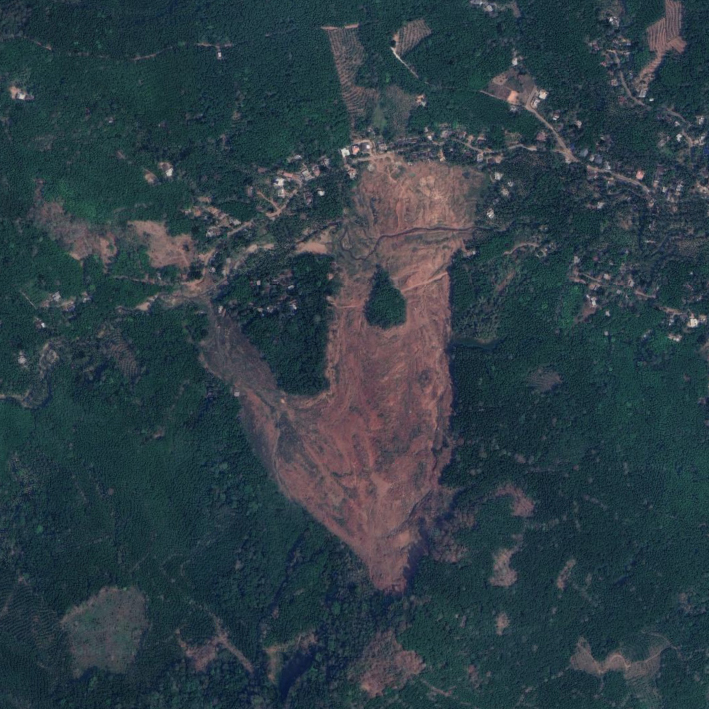

In [53]:
## Visualize new flower with 'sunflower_path'...
PIL.Image.open(landslide_img_one_path)

#### Predict Image One

In [54]:
predict_landslide_image(landslide_img_one_path, ls_model_ph_one)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
This image most likely belongs to non_landslide with a 72.55 percent confidence.


### Image Two

In [29]:
landslide_img_two_url = "https://dl.dropboxusercontent.com/scl/fi/fo985djnnfihvcbe7p05j/NASA_GoogE_13710_NonSlide.jpg?rlkey=dndou59l15fei5edf151j59qo&dl=0?raw=1"
landslide_img_two_path = tf.keras.utils.get_file('NASA_GoogE_13710_NonSlide', origin=landslide_img_two_url)

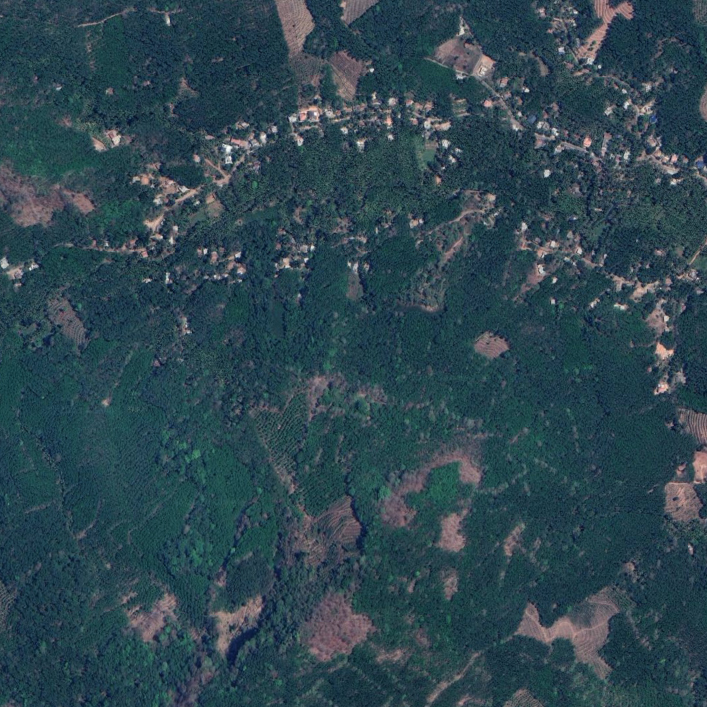

In [47]:
## Visualize new flower with 'sunflower_path'...
PIL.Image.open(landslide_img_two_path)

#### Predict

In [31]:
predict_landslide_image(landslide_img_two_path, ls_model_ph_one)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
This image most likely belongs to non_landslide with a 93.30 percent confidence.
